# Intercomparison

**Author:** Adebowale Adebayo

**Last updated:** March 23, 2024

**Description:** Runs intercomparison and **area estimate** for Kenya 2019

## 1. Setup

In [ ]:
# !earthengine authenticate

In [ ]:
!git clone https://github.com/nasaharvest/crop-mask.git

In [12]:
%cd crop-mask/

/content/crop-mask


In [ ]:
!pip install cartopy -qq
!pip install rasterio -qq
!pip install dvc[gs] -qq

In [ ]:
!git checkout area-estimate-from-multi-land-cover

In [6]:
import ee
import geemap
import sys
import pandas as pd
import numpy as np

import geopandas as gpd
from pathlib import Path

ee.Authenticate()
ee.Initialize(project="bsos-geog-harvest1")

sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL, get_ensemble_area
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


## 2. Read in evaluation set

In [7]:
country = "Kenya"

if country not in TEST_CODE:
    print(f"WARNING: {country} not found in TEST_CODE in src/compare_covermaps.py")
if country not in TEST_COUNTRIES:
    print(f"WARNING: {country} not found in TEST_COUNTRIES in src/compare_covermaps.py")
if country not in TEST_CODE or country not in TEST_COUNTRIES:
    print("Please update src/compare_covermaps.py and restart the notebook.")
else:
    country_code = TEST_CODE[country]

In [13]:
ceo_set1 = './data/ref_samples_area/ceo-Kenya-Crop-Area-Estimation-Reference-Sample-2019---Set-1-sample-data-2024-03-14.csv'
ceo_set2 = './data/ref_samples_area/ceo-Kenya-Crop-Area-Estimation-Reference-Sample-2019---Set-2-sample-data-2024-03-14.csv'

In [14]:
def reference_sample_agree(ceo_ref1, ceo_ref2):
    ceo_ref1 = pd.read_csv(ceo_ref1)
    ceo_ref2 = pd.read_csv(ceo_ref2)

    assert ceo_ref1.columns[-1] == ceo_ref2.columns[-1]

    label_question = ceo_ref1.columns[-1]

    print(f"Number of NANs/ missing answers in set 1: {ceo_ref1[label_question].isna().sum()}")
    print(f"Number of NANs/ missing answers in set 2: {ceo_ref2[label_question].isna().sum()}")

    if ceo_ref1.shape[0] != ceo_ref2.shape[0]:
        print("The number of rows in the reference sets are not equal.")
        print("Checking for duplictes on 'plotid'..")
        print(
            " Number of duplicated in set 1: %s" % ceo_ref1[ceo_ref1.plotid.duplicated()].shape[0]
        )
        print(
            " Number of duplicated in set 2: %s" % ceo_ref2[ceo_ref2.plotid.duplicated()].shape[0]
        )
        print("Removing duplicates and keeping the first...")
        ceo_ref1 = ceo_ref1.drop_duplicates(subset="plotid", keep="first")
        ceo_ref2 = ceo_ref2.drop_duplicates(subset="plotid", keep="first")

        ceo_ref1.set_index("plotid", inplace=True)
        ceo_ref2.set_index("plotid", inplace=True)
    else:
        print("The number of rows in the reference sets are equal.")

    ceo_agree = ceo_ref1[ceo_ref1[label_question] == ceo_ref2[label_question]]

    print(
        "Number of samples that are in agreement: %d out of %d (%.2f%%)"
        % (
            ceo_agree.shape[0],
            ceo_ref1.shape[0],
            ceo_agree.shape[0] / ceo_ref1.shape[0] * 100,
        )
    )
    ceo_agree_geom = gpd.GeoDataFrame(
        ceo_agree,
        geometry=gpd.points_from_xy(ceo_agree.lon, ceo_agree.lat),
        crs="EPSG:4326",
    )

    label_responses = ceo_agree_geom[label_question].unique()
    assert len(label_responses) == 2

    for r, row in ceo_agree_geom.iterrows():

        try:
            if (
                row[label_question].lower() == "crop"
                or row[label_question].lower() == "cropland"
                or row[label_question].lower() == "planted"
            ):
                ceo_agree_geom.loc[r, CLASS_COL] = 1
            elif(
                row[label_question].lower() == "non-crop"
                or row[label_question].lower() == "non-cropland"
                or row[label_question].lower() == "not planted"
            ):
                ceo_agree_geom.loc[r, CLASS_COL] = 0
        except IndexError:
            ceo_agree_geom.loc[r, CLASS_COL] = 255

    ceo_agree_geom = ceo_agree_geom[ceo_agree_geom[CLASS_COL] != 255]

    ceo_agree_geom[CLASS_COL] = ceo_agree_geom[CLASS_COL].astype(int)
    ceo_agree_geom[COUNTRY_COL] = country
    ceo_agree_geom = ceo_agree_geom[['lat','lon',CLASS_COL, COUNTRY_COL, 'geometry']]

    return ceo_agree_geom

In [15]:
gdf = reference_sample_agree(ceo_set1,ceo_set2)
gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

Number of NANs/ missing answers in set 1: 2
Number of NANs/ missing answers in set 2: 0
The number of rows in the reference sets are equal.
Number of samples that are in agreement: 487 out of 544 (89.52%)


## 3. Run intercomparison and area estimation

In [16]:
gdf.head()

,lat,lon,binary,country,geometry
0,2.403553,34.988630,0,Kenya,POINT (34.98863 2.40355)
1,0.237452,40.436913,0,Kenya,POINT (40.43691 0.23745)
2,4.203261,35.525785,0,Kenya,POINT (35.52579 4.20326)
3,1.786133,35.345029,0,Kenya,POINT (35.34503 1.78613)
4,-2.088707,41.092916,1,Kenya,POINT (41.09292 -2.08871)


In [17]:
TARGETS = {k:v for k,v in TARGETS.items()}
for k, v in TARGETS.items():
    if country not in v.countries:
        continue
    if v.year is None:
        v.year = v.collection_years[v.countries.index(country)]

In [19]:
reference_year = 2019
# for i in range(reference_year -1, reference_year+2):
    # print(i)
TARGETS = {k: v for k, v in TARGETS.items() if v.year in range(reference_year - 1, reference_year + 2)} #[reference_year - 1, reference_year, reference_year + 1]}

In [20]:
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")
    gdf.drop_duplicates(inplace=True)  # TODO find why points get duplicated

[Kenya] sampling copernicus...
[Kenya] sampling worldcover-v100...
[Kenya] sampling glad...
[Kenya] sampling dynamicworld...
[Kenya] sampling digital-earth-africa...
[Kenya] sampling esri-lulc...
[Kenya] sampling harvest-crop-maps...


In [21]:
a_j = {}
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] calculating pixel area for " + cropmap.title + "...")
    a_j[cropmap.title] = cropmap.compute_map_area(country, export=True, dataset_name=cropmap.title).copy()

[Kenya] calculating pixel area for copernicus...
[Kenya] calculating pixel area for worldcover-v100...
[Kenya] calculating pixel area for glad...
[Kenya] calculating pixel area for dynamicworld...
[Kenya] calculating pixel area for digital-earth-africa...
[Kenya] calculating pixel area for esri-lulc...
[Kenya] calculating pixel area for harvest-crop-maps...


In [22]:
# update a_j values with exported values
for cropmap in a_j.keys():
    try:
        area_df = pd.read_csv(f'./Crop_NonCrop_Area_Sum_Export-{country}-{cropmap}.csv')
    except:
        continue
    crop_area = int(area_df['crop_sum'][0])
    noncrop_area = int(area_df['noncrop_sum'][0])
    a_j[cropmap] = np.array([noncrop_area, crop_area])

In [23]:
# Change None to nan
a_j = {k: np.array([np.nan, np.nan]) if np.any(v == None) else v for k,v in a_j.items()}

In [24]:
from src.area_utils import compute_area_estimate, compute_area_error_matrix, compute_std_p_i
from sklearn.metrics import confusion_matrix

In [25]:
def compute_area_estimate(dataset, true, pred, a_j, resolution, year):
    cm = confusion_matrix(true, pred)
    total_px = a_j.sum()
    w_j = a_j / total_px

    am = compute_area_error_matrix(cm, w_j)
    a_i = am.sum(axis=1)
    std_a_i = compute_std_p_i(w_j, am, cm)
    err_a_i = 1.96 * std_a_i

    a_px = total_px * a_i
    err_px = err_a_i * total_px
    return pd.DataFrame(
        data={
            "dataset": dataset,
            "area_ha": a_px[1] * (resolution**2) / (100**2),
            "err_ha": err_px[1] * (resolution**2) / (100**2),
            "year": int(year),
        },
        index=[0],
    ).round(2)

In [ ]:
comparisons = []
area_est = []
for cropmap in TARGETS.values():
    cropmap, resolution, year = cropmap.title, cropmap.resolution, cropmap.year
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    area = compute_area_estimate(cropmap, temp[CLASS_COL], temp[cropmap], a_j[cropmap], resolution, year)
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap], a_j[cropmap], area_weighted=True)
    comparisons.append(comparison)
    area_est.append(area)

comparisons = pd.concat(comparisons).set_index(['dataset'])
area_est = pd.concat(area_est).set_index(['dataset'])

results = comparisons.merge(area_est, on='dataset')

In [ ]:
results.to_csv('results.csv')

In [27]:
results[['crop_f1','accuracy','std_acc','crop_recall_pa','std_crop_pa','crop_precision_ua','std_crop_ua','area_ha','err_ha', 'year']]

,crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,crop_precision_ua,std_crop_ua,area_ha,err_ha,year
dataset,,,,,,,,,,
copernicus,0.52,0.86,0.01,0.49,0.05,0.54,0.04,8775032.13,1674917.82,2019
worldcover-v100,0.29,0.84,0.02,0.17,0.01,0.91,0.04,11181466.37,1964935.17,2020
glad,0.56,0.89,0.01,0.47,0.05,0.69,0.04,8504157.39,1587943.81,2019
dynamicworld,NaN,0.00,NaN,NaN,NaN,0.00,0.00,NaN,NaN,2019
digital-earth-africa,0.54,0.88,0.01,0.52,0.03,0.56,0.04,8104337.54,1585223.55,2019
esri-lulc,0.55,0.89,0.01,0.42,0.03,0.76,0.04,8957165.29,1635602.01,2019
harvest-crop-maps,0.47,0.92,0.01,0.47,0.05,0.47,0.03,4536249.04,1366958.88,2019


In [28]:
results.dropna(inplace=True)

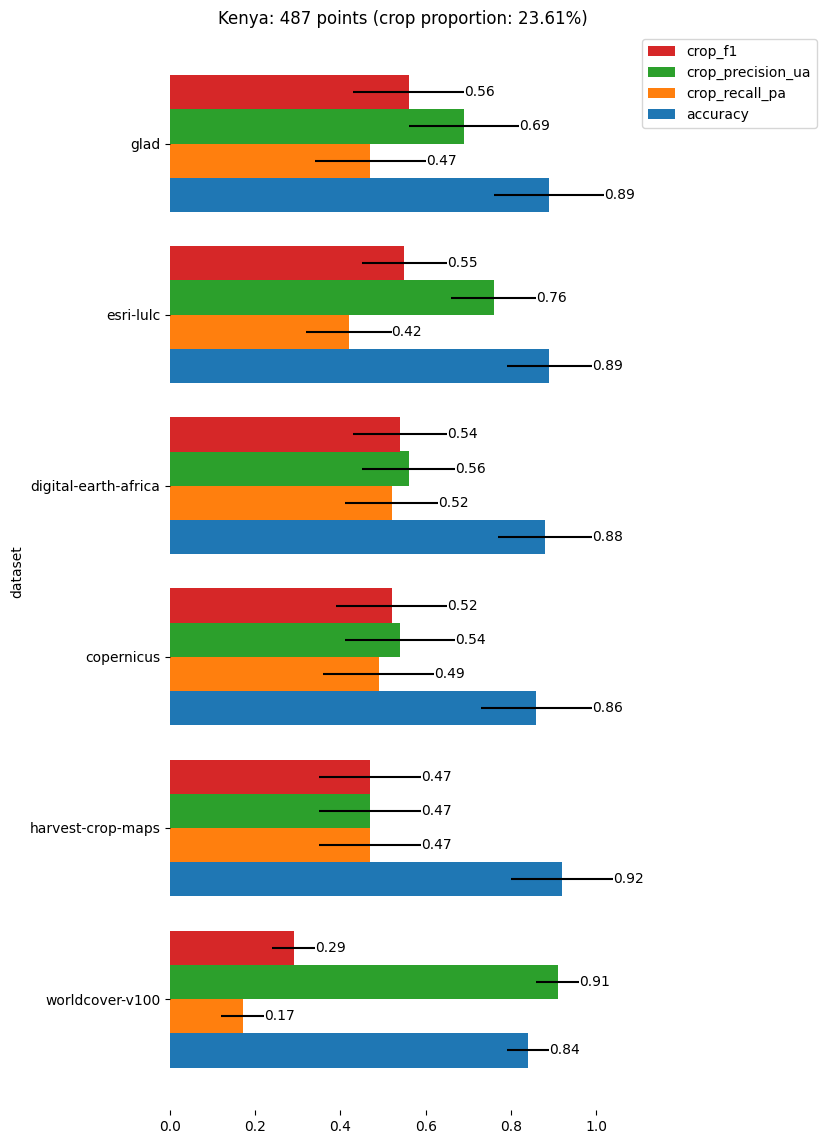

In [29]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"],
    xerr="std_crop_f1",
    kind="barh",
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

## 4. Cropland Area estimates comparsion (FAOSTAT-cropland area included)

In [30]:
fao_stat = pd.read_csv("./data/ref_samples_area/FAOSTAT_data_en_3-13-2024.csv")
fao_stat = fao_stat[fao_stat['Area'] == country]
fao_stat = fao_stat[fao_stat['Year Code'] == reference_year]['Value'] * 1000
results = pd.concat([results, pd.DataFrame({'dataset':['FAOSTAT'], 'area_ha':fao_stat, 'err_ha':0, 'year':reference_year}).set_index(['dataset'])])

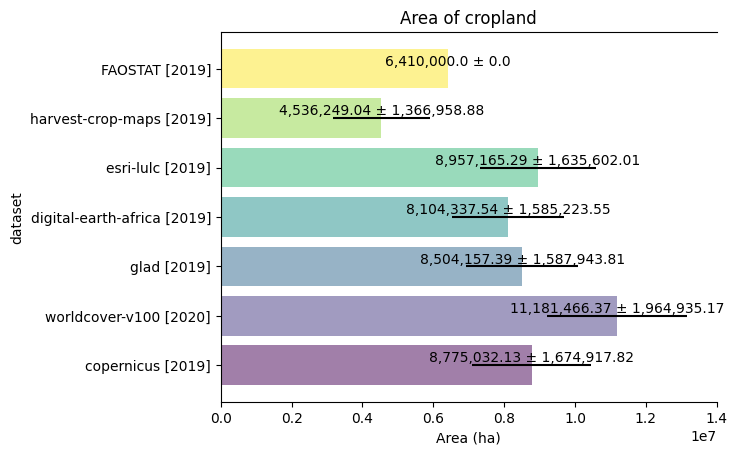

In [33]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

n = len(results)
colors = plt.cm.viridis(np.linspace(0, 1, n))

ax.barh(
    results.index,
    results["area_ha"],
    xerr=results["err_ha"],
    align="center",
    alpha=0.5,
    ecolor="black",
    color= colors
)

ax.set_xticks(ax.get_xticks()); ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f"{dataset} [{int(results.year[dataset])}]" for dataset in results.index])

for i, (value, err) in enumerate(zip(results["area_ha"], results["err_ha"])):
    ax.text(value, i, f"{value:,} ± {err:,}", ha="center", va="bottom")
ax.set_xlabel("Area (ha)")
ax.set_ylabel('dataset')
ax.set_title("Area of cropland")
ax.spines["right"].set_visible(False)
plt.show()